In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.preprocessing as preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer

from Code.utils.dataset import Dataset
import Code.utils.store_model as store_model

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [3]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

#    def compute_mask(self, inputs, mask=None):
#        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [4]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_output.csv')

X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets_unprocessed('Text', 'Label', sep='\t', rem_punctuation=True)

max_words = 10000
max_len = 500

# print(X_train.iloc[0, 0])
# print(X_train.shape)

tokenizer = Tokenizer(num_words=max_words)  # limit to top max_words words
tokenizer.fit_on_texts(X_train.iloc[:, 0])

X_train = tokenizer.texts_to_sequences(X_train.iloc[:, 0])
X_validation = tokenizer.texts_to_sequences(X_validation.iloc[:, 0])
X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_validation = preprocessing.sequence.pad_sequences(X_validation, maxlen=max_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

# print(X_train[0])
# print(X_train.shape)

print(y_train)

[1 0 1 ... 0 1 0]


In [5]:
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(max_len, max_words, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["acc"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs=3, callbacks=callbacks)
model = keras.models.load_model("full_transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalEmbedding": PositionalEmbedding})

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, None, 256)      │     2,688,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, None, 256)      │       543,776 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,033 (12.33 MB)

 Trainable params: 3,232,033 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 613ms/step - acc: 0.7839 - loss: 0.6961 - val_acc: 0.9830 - val_loss: 0.0493
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 691ms/step - acc: 0.9732 - loss: 0.0769 - val_acc: 0.9920 - val_loss: 0.0237
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 764ms/step - acc: 0.9865 - loss: 0.0398 - val_acc: 0.9900 - val_loss: 0.0212


C:\Users\Guilherme Barbosa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\Guilherme Barbosa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:393: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


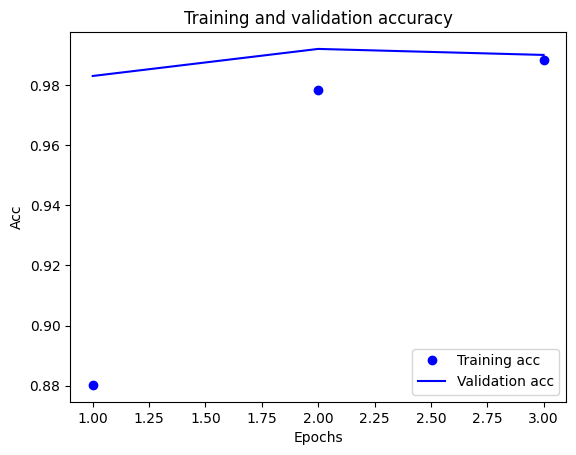

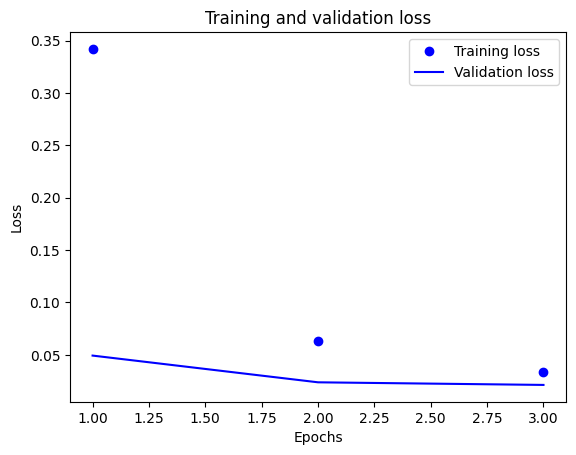

In [6]:
# Plot curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Evaluate Model

results = model.evaluate(X_test, y_test, verbose = 0)
print(results)

[0.01382067147642374, 0.9940000176429749]


In [8]:
# Predict output

output = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step


In [9]:
# Store output

results_filepath = './Results/transformer_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, output)
results.to_csv(results_filepath, sep='\t', index=False)

In [10]:
# Store network model

model_filepath = './Model/transformer'
model_key = 'transformer'

store_model.store_model(model_filepath, model_key, model)

In [11]:
# Retrieve network model

model_filepath = './Model/transformer'
model_key = 'transformer'

model = store_model.retrieve_model(model_filepath, model_key)

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'RMSprop', 'config': {'name': 'rmsprop', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'registered_name': None}, 'loss': 'binary_crossentropy', 'loss_weights': None, 'metrics': ['acc'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: Could not locate class 'PositionalEmbedding'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'PositionalEmbedding', 'config': {'name': 'positional_embedding', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'output_dim': 256, 'sequence_length': 500, 'input_dim': 10000}, 'registered_name': 'PositionalEmbedding', 'build_config': {'input_shape': [None, None]}, 'name': 'positional_embedding', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'int64', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}